In [12]:
import json
import joblib
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [13]:
df = pd.read_csv("data/train.csv")
df.head()

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station
0,2e4d0094-c30b-471b-a211-72a9790feca2,Person search,2020-12-01T01:10:00+00:00,NaN,50.798824,-1.089471,Male,25-34,Other ethnic group - Not stated,White,Police and Criminal Evidence Act 1984 (section 1),Article for use in theft,Community resolution,False,False,hampshire
1,4779fbe8-6e05-4534-85fd-db32952ee309,Person search,2020-12-01T02:00:00+00:00,NaN,50.785099,-1.091540,Male,over 34,White - Any other White background,Other,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,hampshire
2,cb5c685d-acac-42e2-914d-75e6ff73b0a8,Person search,2020-12-01T09:15:00+00:00,NaN,50.952006,-1.403341,Male,over 34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,True,hampshire
3,f486e116-5b1e-45db-9931-a7f070c5c478,Person search,2020-12-01T10:20:00+00:00,NaN,50.806383,-1.079844,Male,10-17,Other ethnic group - Not stated,White,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,A no further action disposal,False,False,hampshire
4,78f4020e-12cc-4889-bf1a-2f2c29b2f662,Person search,2020-12-01T10:24:00+00:00,NaN,50.806670,-1.081982,Male,10-17,Other ethnic group - Not stated,Asian,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,A no further action disposal,False,False,hampshire


You're also given a dictionary explaining what each field means. 

<img src="media/data-dictionary.png" width=900 />

A quick check shows that there is an equivalent for each dataframe field in the data dictionary given.

In [14]:
columns = df.columns
print(columns)

Index(['observation_id', 'Type', 'Date', 'Part of a policing operation',
       'Latitude', 'Longitude', 'Gender', 'Age range',
       'Self-defined ethnicity', 'Officer-defined ethnicity', 'Legislation',
       'Object of search', 'Outcome', 'Outcome linked to object of search',
       'Removal of more than just outer clothing', 'station'],
      dtype='object')


In [15]:
positive_outcome_labels = [
    'Community resolution',
    'Khat or Cannabis warning',
    'Caution (simple or conditional)',
    'Arrest',
    'Penalty Notice for Disorder',
    'Summons / charged by post',
    'Suspect arrested',
    'Suspect summoned to court',
]

In [16]:
df['positive_outcome'] = df['Outcome'].apply(lambda x: True if x in positive_outcome_labels else False)

<br>
    
### Setting up our universe

We'll start by framing the problem and setting up the boundaries for it.

Notice the `VehicleSearchedIndicator` and `ContrabandIndicator` columns. As we have to predict if a car should be searched or not based on the probability of having contraband, the intuition would be that:

* The searched cars should serve as our main data
* The non-searched cars shouldn't provide a lot of info as the lack of search will make the contraband unreliable (and we would expect it to be False)

Let's map out these values:


In [17]:
{"Other":
 [
       'Other ethnic group - Not stated',
       'Other ethnic group - Any other ethnic group',
       'Other ethnic group - Arab',
],

"White":
[
       'White - Any other White background',
       'White - English/Welsh/Scottish/Northern Irish/British',
       'White - Gypsy or Irish Traveller',
],

"Black":
[
       'Black/African/Caribbean/Black British - Any other Black/African/Caribbean background',
       'Black/African/Caribbean/Black British - Caribbean',
       'Black/African/Caribbean/Black British - African', 'White - Irish',
],

"Asian":
[
       'Asian/Asian British - Any other Asian background',
       'Asian/Asian British - Indian',
       'Asian/Asian British - Bangladeshi',
       'Asian/Asian British - Chinese',
       'Asian/Asian British - Pakistani',
],

"Mixed":
[
       'Mixed/Multiple ethnic groups - White and Black African',
       'Mixed/Multiple ethnic groups - White and Asian',
       'Mixed/Multiple ethnic groups - Any other Mixed/Multiple ethnic background',
       'Mixed/Multiple ethnic groups - White and Black Caribbean',
],}

{'Other': ['Other ethnic group - Not stated',
  'Other ethnic group - Any other ethnic group',
  'Other ethnic group - Arab'],
 'White': ['White - Any other White background',
  'White - English/Welsh/Scottish/Northern Irish/British',
  'White - Gypsy or Irish Traveller'],
 'Black': ['Black/African/Caribbean/Black British - Any other Black/African/Caribbean background',
  'Black/African/Caribbean/Black British - Caribbean',
  'Black/African/Caribbean/Black British - African',
  'White - Irish'],
 'Asian': ['Asian/Asian British - Any other Asian background',
  'Asian/Asian British - Indian',
  'Asian/Asian British - Bangladeshi',
  'Asian/Asian British - Chinese',
  'Asian/Asian British - Pakistani'],
 'Mixed': ['Mixed/Multiple ethnic groups - White and Black African',
  'Mixed/Multiple ethnic groups - White and Asian',
  'Mixed/Multiple ethnic groups - Any other Mixed/Multiple ethnic background',
  'Mixed/Multiple ethnic groups - White and Black Caribbean']}

In [18]:
import seaborn as sns

In [19]:
df["Self-defined ethnicity"].replace({"Other":
 [
       'Other ethnic group - Not stated',
       'Other ethnic group - Any other ethnic group',
       'Other ethnic group - Arab',
],

"White":
[
       'White - Any other White background',
       'White - English/Welsh/Scottish/Northern Irish/British',
       'White - Gypsy or Irish Traveller',
],

"Black":
[
       'Black/African/Caribbean/Black British - Any other Black/African/Caribbean background',
       'Black/African/Caribbean/Black British - Caribbean',
       'Black/African/Caribbean/Black British - African', 'White - Irish',
],

"Asian":
[
       'Asian/Asian British - Any other Asian background',
       'Asian/Asian British - Indian',
       'Asian/Asian British - Bangladeshi',
       'Asian/Asian British - Chinese',
       'Asian/Asian British - Pakistani',
],

"Mixed":
[
       'Mixed/Multiple ethnic groups - White and Black African',
       'Mixed/Multiple ethnic groups - White and Asian',
       'Mixed/Multiple ethnic groups - Any other Mixed/Multiple ethnic background',
       'Mixed/Multiple ethnic groups - White and Black Caribbean',
],})

0                           Other ethnic group - Not stated
1                        White - Any other White background
2         White - English/Welsh/Scottish/Northern Irish/...
3                           Other ethnic group - Not stated
4                           Other ethnic group - Not stated
                                ...                        
856605                   White - Any other White background
856606                   White - Any other White background
856607    White - English/Welsh/Scottish/Northern Irish/...
856608    White - English/Welsh/Scottish/Northern Irish/...
856609    White - English/Welsh/Scottish/Northern Irish/...
Name: Self-defined ethnicity, Length: 856610, dtype: object

In [20]:
df.replace({
'Other ethnic group - Not stated': 'Other',
'Other ethnic group - Any other ethnic group': 'Other',
'Other ethnic group - Arab': 'Other',
'White - Any other White background': 'White',
'White - English/Welsh/Scottish/Northern Irish/British': 'White',
'White - Gypsy or Irish Traveller': 'White',
'Black/African/Caribbean/Black British - Any other Black/African/Caribbean background': 'Black',
'Black/African/Caribbean/Black British - Caribbean': 'Black',
'Black/African/Caribbean/Black British - African': 'Black',
'White - Irish': 'Black',
'Asian/Asian British - Any other Asian background': 'Asian',
'Asian/Asian British - Indian': 'Asian',
'Asian/Asian British - Bangladeshi': 'Asian',
'Asian/Asian British - Chinese': 'Asian',
'Asian/Asian British - Pakistani': 'Asian',
'Mixed/Multiple ethnic groups - White and Black African': 'Mixed',
'Mixed/Multiple ethnic groups - White and Asian': 'Mixed',
'Mixed/Multiple ethnic groups - Any other Mixed/Multiple ethnic background': 'Mixed',
'Mixed/Multiple ethnic groups - White and Black Caribbean': 'Mixed'
}).value_counts()

observation_id                        Type                       Date                       Part of a policing operation  Latitude   Longitude  Gender  Age range  Self-defined ethnicity  Officer-defined ethnicity  Legislation                                        Object of search  Outcome                       Outcome linked to object of search  Removal of more than just outer clothing  station             positive_outcome
0000a2cd-cdc2-4a1f-b382-a9416f28a20f  Person search              2021-01-08T10:55:00+00:00  False                         53.813530  -1.518233  Male    18-24      White                   White                      Misuse of Drugs Act 1971 (section 23)              Controlled drugs  A no further action disposal  True                                False                                     west-yorkshire      False               1
aaa38723-7021-4bbd-9a80-0bc361368c41  Person and Vehicle search  2020-02-19T22:01:00+00:00  True                          51.882033   0.932

In [21]:
df.groupby(['Self-defined ethnicity', 
            'Officer-defined ethnicity'])['observation_id'].count().unstack().sum()

Officer-defined ethnicity
Asian    117572
Black    195690
Mixed      2833
Other     28598
White    496734
dtype: int64

In [22]:
df_officer_self_ethnicity_total = (df.replace({
'Other ethnic group - Not stated': 'Other',
'Other ethnic group - Any other ethnic group': 'Other',
'Other ethnic group - Arab': 'Other',
'White - Any other White background': 'White',
'White - English/Welsh/Scottish/Northern Irish/British': 'White',
'White - Gypsy or Irish Traveller': 'White',
'Black/African/Caribbean/Black British - Any other Black/African/Caribbean background': 'Black',
'Black/African/Caribbean/Black British - Caribbean': 'Black',
'Black/African/Caribbean/Black British - African': 'Black',
'White - Irish': 'Black',
'Asian/Asian British - Any other Asian background': 'Asian',
'Asian/Asian British - Indian': 'Asian',
'Asian/Asian British - Bangladeshi': 'Asian',
'Asian/Asian British - Chinese': 'Asian',
'Asian/Asian British - Pakistani': 'Asian',
'Mixed/Multiple ethnic groups - White and Black African': 'Mixed',
'Mixed/Multiple ethnic groups - White and Asian': 'Mixed',
'Mixed/Multiple ethnic groups - Any other Mixed/Multiple ethnic background': 'Mixed',
'Mixed/Multiple ethnic groups - White and Black Caribbean': 'Mixed'
}).groupby(['Self-defined ethnicity', 
            'Officer-defined ethnicity'])['observation_id'].count().unstack()/len(df)*100).round(2)

[Text(0.5, 1.0, 'Percentage of officer-defined ethnicities that correspond to subject self-defined ethnicity')]

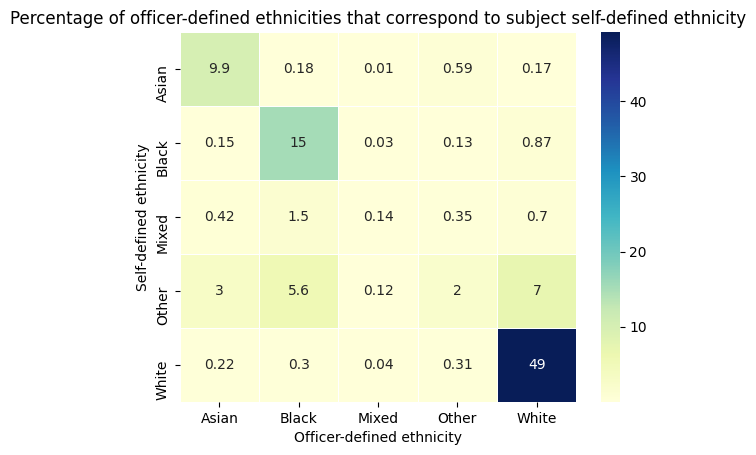

In [23]:
sns.heatmap(df_officer_self_ethnicity_total, annot=True, cmap='YlGnBu', linewidths=.5).set(title='Percentage of officer-defined ethnicities that correspond to subject self-defined ethnicity')

In [24]:
(df.replace({
'Other ethnic group - Not stated': 'Other',
'Other ethnic group - Any other ethnic group': 'Other',
'Other ethnic group - Arab': 'Other',
'White - Any other White background': 'White',
'White - English/Welsh/Scottish/Northern Irish/British': 'White',
'White - Gypsy or Irish Traveller': 'White',
'Black/African/Caribbean/Black British - Any other Black/African/Caribbean background': 'Black',
'Black/African/Caribbean/Black British - Caribbean': 'Black',
'Black/African/Caribbean/Black British - African': 'Black',
'White - Irish': 'Black',
'Asian/Asian British - Any other Asian background': 'Asian',
'Asian/Asian British - Indian': 'Asian',
'Asian/Asian British - Bangladeshi': 'Asian',
'Asian/Asian British - Chinese': 'Asian',
'Asian/Asian British - Pakistani': 'Asian',
'Mixed/Multiple ethnic groups - White and Black African': 'Mixed',
'Mixed/Multiple ethnic groups - White and Asian': 'Mixed',
'Mixed/Multiple ethnic groups - Any other Mixed/Multiple ethnic background': 'Mixed',
'Mixed/Multiple ethnic groups - White and Black Caribbean': 'Mixed'
}).groupby(['Self-defined ethnicity', 
            'Officer-defined ethnicity'])['observation_id'].count().unstack().T/df.replace({
'Other ethnic group - Not stated': 'Other',
'Other ethnic group - Any other ethnic group': 'Other',
'Other ethnic group - Arab': 'Other',
'White - Any other White background': 'White',
'White - English/Welsh/Scottish/Northern Irish/British': 'White',
'White - Gypsy or Irish Traveller': 'White',
'Black/African/Caribbean/Black British - Any other Black/African/Caribbean background': 'Black',
'Black/African/Caribbean/Black British - Caribbean': 'Black',
'Black/African/Caribbean/Black British - African': 'Black',
'White - Irish': 'Black',
'Asian/Asian British - Any other Asian background': 'Asian',
'Asian/Asian British - Indian': 'Asian',
'Asian/Asian British - Bangladeshi': 'Asian',
'Asian/Asian British - Chinese': 'Asian',
'Asian/Asian British - Pakistani': 'Asian',
'Mixed/Multiple ethnic groups - White and Black African': 'Mixed',
'Mixed/Multiple ethnic groups - White and Asian': 'Mixed',
'Mixed/Multiple ethnic groups - Any other Mixed/Multiple ethnic background': 'Mixed',
'Mixed/Multiple ethnic groups - White and Black Caribbean': 'Mixed'
}).groupby(['Self-defined ethnicity', 
            'Officer-defined ethnicity'])['observation_id'].count().unstack().T.sum()*100).round(2)

Self-defined ethnicity,Asian,Black,Mixed,Other,White
Officer-defined ethnicity,,,,,
Asian,91.20,0.90,13.55,17.17,0.45
Black,1.69,92.84,48.00,31.53,0.61
Mixed,0.06,0.16,4.58,0.68,0.07
Other,5.47,0.79,11.28,11.02,0.62
White,1.58,5.31,22.58,39.60,98.25


In [25]:
df_officer_self_ethnicity = (df.replace({
'Other ethnic group - Not stated': 'Other',
'Other ethnic group - Any other ethnic group': 'Other',
'Other ethnic group - Arab': 'Other',
'White - Any other White background': 'White',
'White - English/Welsh/Scottish/Northern Irish/British': 'White',
'White - Gypsy or Irish Traveller': 'White',
'Black/African/Caribbean/Black British - Any other Black/African/Caribbean background': 'Black',
'Black/African/Caribbean/Black British - Caribbean': 'Black',
'Black/African/Caribbean/Black British - African': 'Black',
'White - Irish': 'Black',
'Asian/Asian British - Any other Asian background': 'Asian',
'Asian/Asian British - Indian': 'Asian',
'Asian/Asian British - Bangladeshi': 'Asian',
'Asian/Asian British - Chinese': 'Asian',
'Asian/Asian British - Pakistani': 'Asian',
'Mixed/Multiple ethnic groups - White and Black African': 'Mixed',
'Mixed/Multiple ethnic groups - White and Asian': 'Mixed',
'Mixed/Multiple ethnic groups - Any other Mixed/Multiple ethnic background': 'Mixed',
'Mixed/Multiple ethnic groups - White and Black Caribbean': 'Mixed'
}).groupby(['Self-defined ethnicity', 
            'Officer-defined ethnicity'])['observation_id'].count().unstack()/df.groupby(['Self-defined ethnicity', 
            'Officer-defined ethnicity'])['observation_id'].count().unstack().sum()*100).round(2)

In [26]:
df_officer_self_ethnicity

Officer-defined ethnicity,Asian,Black,Mixed,Other,White
Self-defined ethnicity,,,,,
Asian,72.04,0.80,2.08,17.76,0.30
Black,1.08,66.89,7.73,3.87,1.51
Mixed,3.05,6.49,42.71,10.43,1.20
Other,22.21,24.50,36.43,58.61,12.12
White,1.63,1.33,11.05,9.32,84.87


[Text(0.5, 1.0, 'Percentage of officer-defined ethnicities that correspond to subject self-defined ethnicity')]

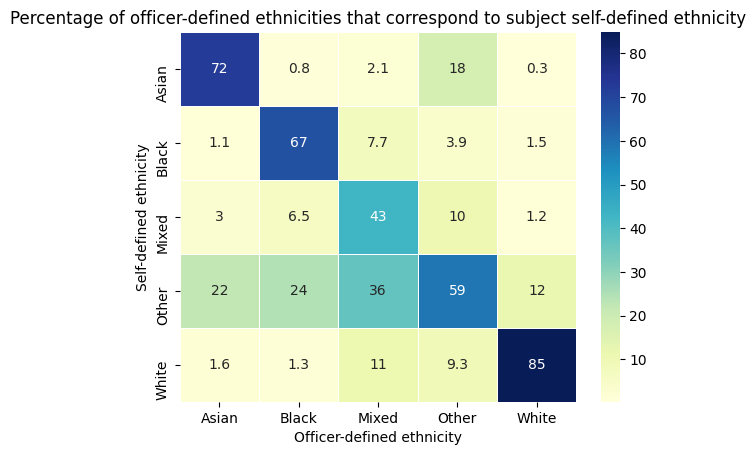

In [27]:
sns.heatmap(df_officer_self_ethnicity, annot=True, cmap='YlGnBu', linewidths=.5).set(title='Percentage of officer-defined ethnicities that correspond to subject self-defined ethnicity')

In [28]:
(df.groupby(['Self-defined ethnicity', 
            'Officer-defined ethnicity'])['observation_id'].count().unstack()/df.groupby(['Self-defined ethnicity', 
            'Officer-defined ethnicity'])['observation_id'].count().unstack().sum()*100).round(2)

Officer-defined ethnicity,Asian,Black,Mixed,Other,White
Self-defined ethnicity,,,,,
Asian/Asian British - Any other Asian background,29.54,0.42,1.27,15.07,0.16
Asian/Asian British - Bangladeshi,13.91,0.10,0.18,0.49,0.02
Asian/Asian British - Chinese,0.50,0.05,0.04,0.38,0.01
Asian/Asian British - Indian,8.58,0.10,0.25,0.39,0.04
Asian/Asian British - Pakistani,19.51,0.13,0.35,1.42,0.06
Black/African/Caribbean/Black British - African,0.44,21.54,0.42,2.19,0.09
Black/African/Caribbean/Black British - Any other Black/African/Caribbean background,0.47,30.89,5.40,1.38,0.13
Black/African/Caribbean/Black British - Caribbean,0.14,14.43,1.80,0.24,0.07
Mixed/Multiple ethnic groups - Any other Mixed/Multiple ethnic background,1.44,1.99,21.57,7.84,0.83


In [29]:
# Obtaining the crossed amounts of cars searched and the amount of contraband found 

df.groupby(['Outcome linked to object of search', 
            'positive_outcome'])['Date'].count().unstack()



positive_outcome,False,True
Outcome linked to object of search,,
False,110662,28461
True,45153,70407


We have around 70K examples of cars searched which we can directly use, and over 2M that weren't searched. From those, however, we have almost 3K that are listed as having contraband. Let's assume those are cases where the contraband was so obvious that it did not require a search. If we make this assumption then we would want to use this data as the contraband is fairly obvious, otherwise you can discard it.

<img src="media/polices_search.jpeg" width=400 />



The other columns are our potential features. We should take a look into each to get information about:

* their type
* the potential values, which should corroborate the information given when applicable


For example, we can check the subject's age, verify the type is what we expect and check the values it can take:

In [30]:
## Subject Age

# df.hist(column='SubjectAge', bins=20, figsize=(6, 4));
# plt.xlabel('Age');
# plt.ylabel('Count');


Something that stands out is the small but visible column in the 0-5 category. These are obviously impossible and we need to handle them somehow. But let's leave that for later on.

Let's now check one of the code-like columns:

In [31]:
df['Officer-defined ethnicity'].value_counts()/len(df)

White    0.592600
Black    0.230136
Asian    0.139836
Other    0.033895
Mixed    0.003533
Name: Officer-defined ethnicity, dtype: float64

In [32]:
df['Gender'].value_counts()/len(df)

Male      0.904222
Female    0.094721
Other     0.001056
Name: Gender, dtype: float64

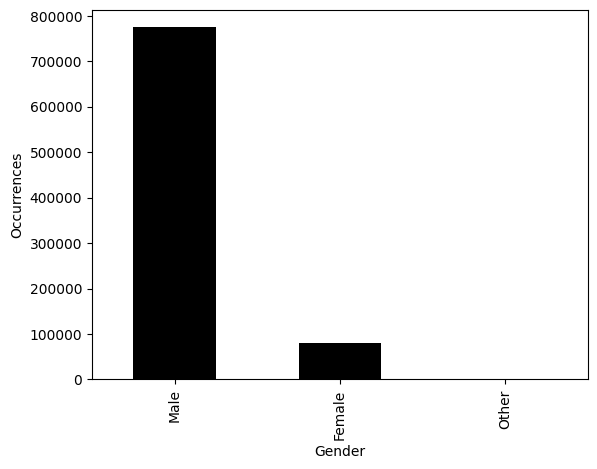

In [33]:
df['Gender'].value_counts().plot(kind='bar', color='black');
plt.xlabel('Gender');
plt.ylabel('Occurrences');

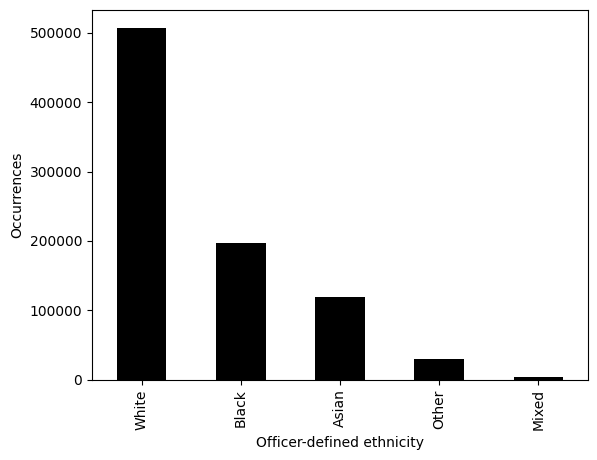

In [34]:
## Subject Race

df['Officer-defined ethnicity'].value_counts().plot(kind='bar', color='black');
plt.xlabel('Officer-defined ethnicity');
plt.ylabel('Occurrences');


There's a clear disparity between samples for each race, which can cause issues to make sure there is no discrimination. In particular, only the two first race groups (White and Black) have a significant amount of examples.

This might be a problem not only to train your model but to efficiently analyze its biases. We might need to come back to this.

For now, let's move forward and analyze one more categorical feature:



In [35]:
df["Object of search"].value_counts()/len(df)

Controlled drugs                                  0.651522
Offensive weapons                                 0.131509
Stolen goods                                      0.088369
Article for use in theft                          0.045185
Evidence of offences under the Act                0.026943
Articles for use in criminal damage               0.019491
Anything to threaten or harm anyone               0.018135
Firearms                                          0.006327
Fireworks                                         0.005921
Psychoactive substances                           0.005609
Game or poaching equipment                        0.000375
Detailed object of search unavailable             0.000361
Goods on which duty has not been paid etc.        0.000113
Crossbows                                         0.000063
Evidence of wildlife offences                     0.000054
Evidence of hunting any wild mammal with a dog    0.000014
Seals or hunting equipment                        0.0000

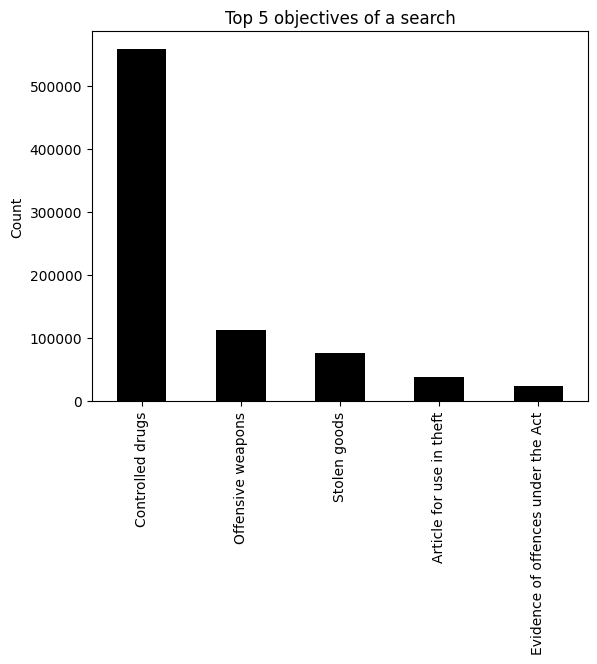

In [36]:
df["Object of search"].value_counts().nlargest(5).plot(kind='bar', color='black', title='Top 5 objectives of a search');
plt.ylabel('Count');


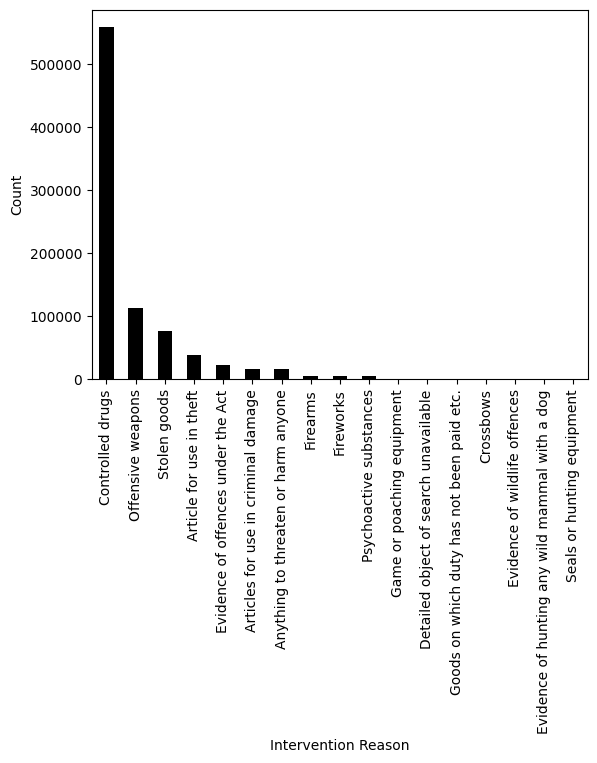

In [37]:
## Intervention reason code

df["Object of search"].value_counts().plot(kind='bar', color='black');
plt.xlabel('Intervention Reason');
plt.ylabel('Count');


In this case, for example, we have the three expected values and an unexpected value, which we will need to handle somehow. 

You should do a similar analysis and get quite acquainted with the current information in your dataset. We won't show the same breakdown for all features but do play around with them to get familiar with what they mean.

<br>

### Unexpected values

But let's go back to our **unexpected values**. There will be cases where new values are acceptable because your features don't have a closed space, and cases where different values are just not acceptable. 

To deal with those, we can make decisions on either to drop rows with unexpected values or to convert them to a specific default flag, if applicable (for example if you have a flag "other"/"unknown"/etc). In some cases, those will be obvious and in some, you'll have to make explicit decisions that you need to debate with your client or your users. 

For now, let's tackle this by creating a map for all our well-defined columns with our expected values and defaults, if relevant. 

In [38]:
known_categories = {
    "InterventionReasonCode": {"values": ["V", "E", "I"], "default": None},
    "SubjectRaceCode": {"values": ["W", "B", "A", "I"], "default": None},
    "SubjectSexCode": {"values": ["M", "F"], "default": None},
    "SubjectEthnicityCode": {"values": ["H", "M", "N"], "default": "N"},
    "SearchAuthorizationCode": {"values": ["O", "I", "C", "N"], "default": "N"},
    # We can use it also for booleans!
    "TownResidentIndicator": {"values": [True, False]}, 
    "ResidentIndicator": {"values": [True, False]},
    "VehicleSearchedIndicator": {"values": [True, False]},
    "ContrabandIndicator": {"values": [True, False]},
}


This is a way of formalizing our setup and can later on be reused to serve our models, but for now we will create a small function to perform a clean-up of the dataframe and apply it to the original dataset.

In [39]:
df[["Outcome linked to object of search", "Removal of more than just outer clothing", "Part of a policing operation"]] = df[["Outcome linked to object of search", "Removal of more than just outer clothing", "Part of a policing operation"]].fillna(False)

In [40]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856610 entries, 0 to 856609
Data columns (total 17 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   observation_id                            856610 non-null  object 
 1   Type                                      856610 non-null  object 
 2   Date                                      856610 non-null  object 
 3   Part of a policing operation              856610 non-null  bool   
 4   Latitude                                  700308 non-null  float64
 5   Longitude                                 700308 non-null  float64
 6   Gender                                    856610 non-null  object 
 7   Age range                                 856610 non-null  object 
 8   Self-defined ethnicity                    841427 non-null  object 
 9   Officer-defined ethnicity                 856610 non-null  object 
 10  Legislation         

In [41]:
# df_clean = df.drop(columns=['Latitude', 'Longitude'])

In [43]:
df_clean = df

In [44]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 856610 entries, 0 to 856609
Data columns (total 17 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   observation_id                            856610 non-null  object 
 1   Type                                      856610 non-null  object 
 2   Date                                      856610 non-null  object 
 3   Part of a policing operation              856610 non-null  bool   
 4   Latitude                                  700308 non-null  float64
 5   Longitude                                 700308 non-null  float64
 6   Gender                                    856610 non-null  object 
 7   Age range                                 856610 non-null  object 
 8   Self-defined ethnicity                    841427 non-null  object 
 9   Officer-defined ethnicity                 856610 non-null  object 
 10  Legislation         

In [45]:
df_clean = df_clean.dropna()

In [ ]:
# def resolve_unexpected(df, known_categories):
#     processed_df = df.copy()
#     defaults = 0
#     dropped = 0
    
#     for column in known_categories.keys():
#         mapping = known_categories[column]
#         bad_rows = processed_df[~processed_df[column].isin(mapping.get('values'))].index
#         if bad_rows.empty:
#             continue
#         if mapping.get('default'):
#             processed_df.iloc[bad_rows, df.columns.get_loc(column)] = mapping.get('default')
#             defaults += len(bad_rows)
#         else:
#             processed_df.drop(bad_rows, inplace=True)
#             dropped += len(bad_rows)
            
#     return processed_df, defaults, dropped
        

In [ ]:
# df_clean, defaults, dropped = resolve_unexpected(df, known_categories)

In [ ]:
# print("Updated {} to default. Dropped {}".format(defaults, dropped))

In [46]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 680695 entries, 0 to 856609
Data columns (total 17 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   observation_id                            680695 non-null  object 
 1   Type                                      680695 non-null  object 
 2   Date                                      680695 non-null  object 
 3   Part of a policing operation              680695 non-null  bool   
 4   Latitude                                  680695 non-null  float64
 5   Longitude                                 680695 non-null  float64
 6   Gender                                    680695 non-null  object 
 7   Age range                                 680695 non-null  object 
 8   Self-defined ethnicity                    680695 non-null  object 
 9   Officer-defined ethnicity                 680695 non-null  object 
 10  Legislation         

So the dataset was pretty clean, but this will already prevent these sneaky examples to bite us later on.
<br>


### Data normalization

After a bit more analysis, you should have noticed also that there is a date column representing the intervention date and time, both following an American format. For our baseline, we'll ignore the time element and parse the date into some features that can be used regardless, such as hour of day, day of week and month.


In [47]:
def verify_no_discrimination(X_test, y_true, y_pred, sensitive_column='SubjectRaceCode', max_diff=0.05):
    """
    Verifies that no subdeparment has discrimination in between protected races
    
    
    """
    
    departments = X_test['station'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    problematic_departments = []
    good_deparments = []
    for department in departments:
        precisions = {}
        for sensitive_class in sensitive_classes:
            mask = (X_test[sensitive_column] == sensitive_class) & (X_test['station'] == department)
            if mask.sum():
                precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1, zero_division=0)
                
        diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
        if diff > max_diff:
            is_satisfied = False
            problematic_departments.append((department, diff, precisions))
        else:
            good_deparments.append((department, diff, precisions))

    return is_satisfied, problematic_departments, good_deparments



In [38]:
verify_no_discrimination(df_clean, df_clean["Outcome linked to object of search"], df_clean["positive_outcome"], sensitive_column='Officer-defined ethnicity', max_diff=0.05)

(False,
 [('hampshire',
   0.08871090770404277,
   {'White': 0.8630585516178737,
    'Other': 0.8613861386138614,
    'Asian': 0.868421052631579,
    'Black': 0.7797101449275362}),
  ('sussex',
   0.08020050125313283,
   {'White': 0.6744645799011532,
    'Other': 0.6666666666666666,
    'Asian': 0.6766917293233082,
    'Black': 0.5964912280701754}),
  ('south-yorkshire',
   0.12865307689078398,
   {'White': 0.33906071019473083,
    'Other': 0.3939393939393939,
    'Asian': 0.4677137870855148,
    'Black': 0.4192872117400419}),
  ('staffordshire',
   0.20151828847481024,
   {'White': 0.6347114947751022,
    'Other': 0.4444444444444444,
    'Asian': 0.6459627329192547,
    'Black': 0.5836909871244635}),
  ('bedfordshire',
   0.05193315858453473,
   {'White': 0.8230668414154653,
    'Other': 0.85,
    'Asian': 0.8434782608695652,
    'Black': 0.875}),
  ('cumbria',
   0.13379923761118173,
   {'White': 0.7662007623888183,
    'Other': 0.9,
    'Asian': 0.8260869565217391,
    'Black': 0.85

In [39]:
is_satisfied, problematic_departments, good_deparments = verify_no_discrimination(df_clean, df_clean["Outcome linked to object of search"], df_clean["positive_outcome"], sensitive_column='Self-defined ethnicity', max_diff=0.05)


if not is_satisfied:
    print("Requirement failed 😢")
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))

    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
        
print("\n\nGender")

is_satisfied, problematic_departments, good_deparments = verify_no_discrimination(df_clean, df_clean["Outcome linked to object of search"], df_clean["positive_outcome"], sensitive_column='Gender', max_diff=0.05)

if not is_satisfied:
    print("Requirement failed 😢")
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))

    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
        
        
print("\nEthnicity")

is_satisfied, problematic_departments, good_deparments = verify_no_discrimination(df_clean, df_clean["Outcome linked to object of search"], df_clean["positive_outcome"], sensitive_column='Officer-defined ethnicity', max_diff=0.05)

if not is_satisfied:
    print("Requirement failed 😢")
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))

    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
else:
    print("Requirement satisfied! 🚀")

print("Departments analysed: {}".format(len(problematic_departments) + len(good_deparments)))

Requirement failed 😢
Num problematic departments: 34
Num good departments: 6
avg diff: 0.6854121756279445


Gender
Requirement failed 😢
Num problematic departments: 21
Num good departments: 19
avg diff: 0.2887411671865024

Ethnicity
Requirement failed 😢
Num problematic departments: 31
Num good departments: 9
avg diff: 0.15763476367546075
Departments analysed: 40


In [ ]:
df_clean.station.value_counts()

metropolitan          436819
merseyside             38170
west-yorkshire         24976
south-yorkshire        23385
hampshire              20229
btp                    18376
kent                   17573
hertfordshire          13960
lancashire             13646
avon-and-somerset      12933
essex                  12888
sussex                 11145
west-mercia             9160
humberside              9065
staffordshire           9030
norfolk                 8727
west-midlands           8714
leicestershire          8298
cheshire                8271
devon-and-cornwall      8089
northumbria             7876
cleveland               7537
nottinghamshire         7522
north-wales             6624
suffolk                 6458
bedfordshire            5890
lincolnshire            5023
dyfed-powys             4663
city-of-london          4539
northamptonshire        4400
warwickshire            3837
durham                  3585
gloucestershire         3542
thames-valley           3470
cambridgeshire

In [48]:
df_clean = df_clean.loc[df_clean['station']!='metropolitan']

In [49]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 289959 entries, 0 to 856609
Data columns (total 17 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   observation_id                            289959 non-null  object 
 1   Type                                      289959 non-null  object 
 2   Date                                      289959 non-null  object 
 3   Part of a policing operation              289959 non-null  bool   
 4   Latitude                                  289959 non-null  float64
 5   Longitude                                 289959 non-null  float64
 6   Gender                                    289959 non-null  object 
 7   Age range                                 289959 non-null  object 
 8   Self-defined ethnicity                    289959 non-null  object 
 9   Officer-defined ethnicity                 289959 non-null  object 
 10  Legislation         

In [50]:
df_base = df_clean.copy()

# beware american timestamps, where the month comes before day 
df_base['Date'] = pd.to_datetime(df_base['Date'])

# get the hour and day of the week, maybe they will be useful 
df_base['hour'] = df_base['Date'].dt.hour
df_base['month'] = df_base['Date'].dt.month
df_base['day_of_week'] = df_base['Date'].dt.day_name()


We will also do some very very simple normalization of the text fields in our dataframe.

In [51]:
# Lowercase deparment name and location
df_base['station'] = df_base['station'].apply(lambda x: str(x).lower())
# df_base['InterventionLocationName'] = df_base['InterventionLocationName'].apply(lambda x: str(x).lower())


df_base = df_base.dropna()

Finally, we'll drop the weird age values that don't seem to add up.

In [52]:
# # Get indexes where age is unreasonably low
# indexAge = df_base[df_base['SubjectAge'] < 10].index
 
# # Delete these row indexes from dataFrame
# df_base.drop(indexAge, inplace=True)
             
df_base.head()


,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Self-defined ethnicity,Officer-defined ethnicity,Legislation,Object of search,Outcome,Outcome linked to object of search,Removal of more than just outer clothing,station,positive_outcome,hour,month,day_of_week
0,2e4d0094-c30b-471b-a211-72a9790feca2,Person search,2020-12-01 01:10:00+00:00,False,50.798824,-1.089471,Male,25-34,Other ethnic group - Not stated,White,Police and Criminal Evidence Act 1984 (section 1),Article for use in theft,Community resolution,False,False,hampshire,True,1,12,Tuesday
1,4779fbe8-6e05-4534-85fd-db32952ee309,Person search,2020-12-01 02:00:00+00:00,False,50.785099,-1.091540,Male,over 34,White - Any other White background,Other,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,False,hampshire,False,2,12,Tuesday
2,cb5c685d-acac-42e2-914d-75e6ff73b0a8,Person search,2020-12-01 09:15:00+00:00,False,50.952006,-1.403341,Male,over 34,White - English/Welsh/Scottish/Northern Irish/...,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,A no further action disposal,False,True,hampshire,False,9,12,Tuesday
3,f486e116-5b1e-45db-9931-a7f070c5c478,Person search,2020-12-01 10:20:00+00:00,False,50.806383,-1.079844,Male,10-17,Other ethnic group - Not stated,White,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,A no further action disposal,False,False,hampshire,False,10,12,Tuesday
4,78f4020e-12cc-4889-bf1a-2f2c29b2f662,Person search,2020-12-01 10:24:00+00:00,False,50.806670,-1.081982,Male,10-17,Other ethnic group - Not stated,Asian,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,A no further action disposal,False,False,hampshire,False,10,12,Tuesday


### Dataset split

We'll do a random split with scikitlearn that will be re-used through the rest of the notebook.

**Note**: We are ignoring the temporal nature of the data for now, as it is not relevant for the purpose of these examples, but keep in mind that you might want to include that if you were working on the problem for real.


In [53]:
df_search = df_base[(df_base['positive_outcome'] == True) | (df_base['Outcome linked to object of search'] == True) ]

df_train, df_test = train_test_split(df_search, test_size=0.3, random_state=42)



### Training a baseline model

We'll now train a baseline model for the problem. As we're aiming for a simple baseline, we're going to use almost all available features and train a simple classifier using:

- one hot encoding for our categorical features
- a standard scaler for our numerical features

Run the pipeline below to train the baseline.



In [54]:
df_train.columns

Index(['observation_id', 'Type', 'Date', 'Part of a policing operation',
       'Latitude', 'Longitude', 'Gender', 'Age range',
       'Self-defined ethnicity', 'Officer-defined ethnicity', 'Legislation',
       'Object of search', 'Outcome', 'Outcome linked to object of search',
       'Removal of more than just outer clothing', 'station',
       'positive_outcome', 'hour', 'month', 'day_of_week'],
      dtype='object')

In [55]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82541 entries, 57312 to 115884
Data columns (total 20 columns):
 #   Column                                    Non-Null Count  Dtype              
---  ------                                    --------------  -----              
 0   observation_id                            82541 non-null  object             
 1   Type                                      82541 non-null  object             
 2   Date                                      82541 non-null  datetime64[ns, UTC]
 3   Part of a policing operation              82541 non-null  bool               
 4   Latitude                                  82541 non-null  float64            
 5   Longitude                                 82541 non-null  float64            
 6   Gender                                    82541 non-null  object             
 7   Age range                                 82541 non-null  object             
 8   Self-defined ethnicity                    82541 non

In [56]:
df_clean[[
    'observation_id',
    'Type',
    'Date',
    'Part of a policing operation',
    'Latitude',
    'Longitude',
    'Gender',
    'Age range',
    'Officer-defined ethnicity',
    'Legislation',
    'Object of search',
    'station',
]]

,observation_id,Type,Date,Part of a policing operation,Latitude,Longitude,Gender,Age range,Officer-defined ethnicity,Legislation,Object of search,station
0,2e4d0094-c30b-471b-a211-72a9790feca2,Person search,2020-12-01T01:10:00+00:00,False,50.798824,-1.089471,Male,25-34,White,Police and Criminal Evidence Act 1984 (section 1),Article for use in theft,hampshire
1,4779fbe8-6e05-4534-85fd-db32952ee309,Person search,2020-12-01T02:00:00+00:00,False,50.785099,-1.091540,Male,over 34,Other,Misuse of Drugs Act 1971 (section 23),Controlled drugs,hampshire
2,cb5c685d-acac-42e2-914d-75e6ff73b0a8,Person search,2020-12-01T09:15:00+00:00,False,50.952006,-1.403341,Male,over 34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,hampshire
3,f486e116-5b1e-45db-9931-a7f070c5c478,Person search,2020-12-01T10:20:00+00:00,False,50.806383,-1.079844,Male,10-17,White,Police and Criminal Evidence Act 1984 (section 1),Stolen goods,hampshire
4,78f4020e-12cc-4889-bf1a-2f2c29b2f662,Person search,2020-12-01T10:24:00+00:00,False,50.806670,-1.081982,Male,10-17,Asian,Police and Criminal Evidence Act 1984 (section 1),Offensive weapons,hampshire
...,...,...,...,...,...,...,...,...,...,...,...,...
856605,ee337b9a-12ad-45fd-8c60-49091a0f4ab8,Person and Vehicle search,2020-04-30T15:10:00+00:00,False,54.965502,-1.604609,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,northumbria
856606,5973a004-e579-4dd2-bc26-71ab5717f87a,Person and Vehicle search,2020-04-30T15:10:00+00:00,False,54.965502,-1.604609,Male,25-34,Other,Misuse of Drugs Act 1971 (section 23),Controlled drugs,northumbria
856607,ad053a34-364e-4d24-8f5c-9734ab5fdbe0,Person and Vehicle search,2020-04-30T17:00:00+00:00,False,54.966266,-1.453704,Male,18-24,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,northumbria
856608,8736e5ec-7ca2-420b-ad56-4dd88d27fe6e,Person search,2020-04-30T17:35:00+00:00,False,54.971596,-1.636589,Male,25-34,White,Misuse of Drugs Act 1971 (section 23),Controlled drugs,northumbria


In [57]:
selected_columns = [
 'Type',
 'Gender',
 'Age range',
 'Officer-defined ethnicity',
 'Object of search',
 'station',
]

In [ ]:
all_features = selected_columns

In [58]:
from sklearn.base import TransformerMixin, BaseEstimator
import pandas as pd

class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        return X[self.columns]

In [ ]:
target = 'ContrabandIndicator'

In [ ]:
# target = 'ContrabandIndicator'

# all_features = [
#   'SubjectRaceCode',
#   'SubjectSexCode',
#   'SubjectEthnicityCode',
#   'StatuteReason', 
#   'InterventionReasonCode',
#   'ResidentIndicator',
#   'SearchAuthorizationCode',
#   'SubjectAge',
#   'hour',
#   'day_of_week'
# ]

# numerical_features = ['SubjectAge', 'hour']
# categorical_features = [
#   'SubjectRaceCode',
#   'SubjectSexCode',
#   'SubjectEthnicityCode',
#   'StatuteReason', 
#   'InterventionReasonCode',
#   'ResidentIndicator',
#   'SearchAuthorizationCode',
#   'day_of_week'
# ]

# numeric_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='median')),
#     ('scaler', StandardScaler())])

# categorical_transformer = Pipeline(steps=[
#     ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
#     ('onehot', OneHotEncoder(handle_unknown='ignore'))])

# preprocessor = ColumnTransformer(
#     transformers=[
#         ('num', numeric_transformer, numerical_features),
#         ('cat', categorical_transformer, categorical_features)])

In [60]:
pipeline = make_pipeline(
    ('column_selector', ColumnTransformer([("selector", "passthrough", selected_columns)], remainder="drop")),
    ('onehot', OneHotEncoder(handle_unknown='ignore')),
    ('classifier', RandomForestClassifier(max_depth=3, min_samples_leaf=.03, class_weight="balanced", random_state=42, n_jobs=-1)),
)


X_train = df_train[all_features]
y_train = df_train[target]

pipeline.fit(X_train, y_train)

X_test = df_test[all_features]
y_test = df_test[target]

y_pred = pipeline.predict(X_test)
y_pred_train = pipeline.predict(X_train)

# To use on other cells
X_train_baseline = X_train.copy()
X_test_baseline = df_test.copy()
y_test_baseline = X_test_baseline[target].copy()
y_pred_baseline = y_pred.copy()
pipeline_baseline = pipeline

roc_auc_score(y_test, y_pred)

TypeError: All intermediate steps should be transformers and implement fit and transform or be the string 'passthrough' '('column_selector', ColumnTransformer(transformers=[('selector', 'passthrough',
                                 ['Type', 'Gender', 'Age range',
                                  'Officer-defined ethnicity',
                                  'Object of search', 'station'])]))' (type <class 'tuple'>) doesn't

In [16]:



# pipeline = make_pipeline(
#     preprocessor,
#     RandomForestClassifier(max_depth=3, min_samples_leaf=.03, class_weight="balanced", random_state=42, n_jobs=-1),
# )


# X_train = df_train[all_features]
# y_train = df_train[target]

# pipeline.fit(X_train, y_train)

# X_test = df_test[all_features]
# y_test = df_test[target]

# y_pred = pipeline.predict(X_test)
# y_pred_train = pipeline.predict(X_train)

# # To use on other cells
# X_train_baseline = X_train.copy()
# X_test_baseline = df_test.copy()
# y_test_baseline = X_test_baseline[target].copy()
# y_pred_baseline = y_pred.copy()
# pipeline_baseline = pipeline

# roc_auc_score(y_test, y_pred)


0.6687788339252474

We can also see what are the most important features in our model, which should give us some intuition of what type of information it is prioritizing.


Feature ranking:
1. feature SearchAuthorizationCode_O (0.258803)
2. feature SearchAuthorizationCode_C (0.202273)
3. feature SearchAuthorizationCode_I (0.194072)
4. feature SubjectAge (0.115865)
5. feature SearchAuthorizationCode_N (0.061532)
6. feature StatuteReason_Registration (0.031616)
7. feature SubjectRaceCode_B (0.030741)
8. feature StatuteReason_Other (0.023039)
9. feature SubjectRaceCode_W (0.018665)
10. feature SubjectEthnicityCode_H (0.018373)


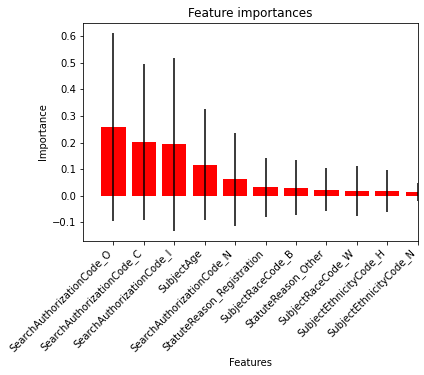

In [17]:
categorical_encode_step = pipeline.named_steps['columntransformer'].named_transformers_['cat'].named_steps['onehot']
random_forest_step = pipeline.named_steps['randomforestclassifier']

onehot_columns = categorical_encode_step.get_feature_names(input_features=categorical_features)

importances = pd.Series(data=random_forest_step.feature_importances_, index = np.array(numerical_features + list(onehot_columns)))

indices = np.argsort(importances)[::-1]
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %s (%f)" % (f + 1, importances.index[indices[f]], importances[indices[f]]))

std = np.std([tree.feature_importances_ for tree in random_forest_step.estimators_], axis=0)

plt.figure()
plt.title("Feature importances")
plt.bar(x=importances.index[indices], height=importances[indices],
        color="r", yerr=std[indices], align="center");
plt.xticks(range(len(importances.index[indices])), importances.index[indices], rotation=45, ha="right")
plt.xlim([-1, X_train.shape[1]])
plt.xlabel('Features');
plt.ylabel('Importance');

plt.show()


So it seems like search authorization code is one of the most important requirements. In particular, the case of "O" - other situations such as Probable Cause, Reasonable Suspicion, Plain View Contraband, Incident to Arrest, Drug Dog Alert, Exigent Circumstances - seems to have a great impact on our model. 

Intuitively this makes sense, but keep in mind this might not be the best of features, as it assumes there is already a previous model to suggest a search. But we'll come back to that later.

Now that we have our baseline, does it pass the clients' requirements?

<br>

### Formalizing client requirements

We'll now go back to our client requirements. They were the following:

- A minimum 50% success rate for searches (when a car is searched, it should be at least 50% likely that contraband is found)
- No police sub-department should have a discrepancy bigger than 5% between the search success rate between protected classes (race, ethnicity, gender)  
- To find the largest possible amount of contraband, given the constraints above. 

So, let's analyze each one step by step and see if our baseline model satisfies them or needs to be adjusted.

###  1 - Minimum 50% success rate for searches

Let's break it down:

This means that what we want is:

- from all the searches that our model outputs - a.k.a total positive labels
- we want at least a percentage to be correct - a.k.a true positives labels

_Sounds familiar?_ 


$$
Precision = \frac{True Positives}{Total Predicted Positives} =  \frac{True Positives}{True Positives + False Positives} 
$$


    
This just means we want a precision above 0.5. Let's design a tiny function to verify this requirement:

In [18]:
def verify_success_rate_above(y_true, y_pred, min_success_rate=0.1):
    """
    Verifies the success rate on a test set is above a provided minimum
    
    
    """
    
    precision = precision_score(y_true, y_pred, pos_label=True)
    is_satisfied = (precision >= min_success_rate)
    
    return is_satisfied, precision


We can now run the function on our baseline model.

In [19]:
is_verified, success_rate = verify_success_rate_above(y_test_baseline, y_pred_baseline)

print(is_verified, success_rate)

True 0.5340273761326393


Awesome, it seems like we pass the first requirement, even with just the baseline. Now let's see how we fare on the second one:

<br>

###  2 - No police sub-department should have a discrepancy bigger than 5% between the search success rate between protected classes (race, ethnicity, gender)

Let's break it down:

- for the predictions of each police sub-department
- the success rates - a.k.a **precision** - for each protected class 
- should NOT differ by more than 5% 

If we have the following test set:

| Police department |   P1    |   P2   |  P3   |  P4   |
|-------------------|---------|--------|-------|-------| 
| White |    5000       |     10   |  20000    | 5000  |
| Black |   10000       |  20000   |     10    | 5000  |
| Asian |    2000       |   1000   |     40    | 5000  |


And model 1 has the following precisions:

| Police department |   P1    |   P2   |  P3   |  P4   |
|-------------------|---------|--------|-------|-------| 
| White |    0.55   |   0.9   |  0.51  | 0.61  |
| Black |    0.5    |   0.53  |  0.2   | 0.62  |
| Asian |    0.51   |   0.5   |  0.9   | 0.59  |


Does it satisfy these requirements?

First, let's add the difference between classes:

| Police department |   P1    |   P2   |  P3   |  P4   |
|-------------------|---------|--------|-------|-------| 
| Diff_white_black |    0.05  |  0.37  |  0.29 | 0.01  |
| Diff_white_asian |    0.04  |  0.4   |  0.39 | 0.02  |
| Diff_black_asian |    0.01  |  0.03  |  0.7  | 0.03  |
| Max diff         |    0.05  |  0.4   |  0.7  | 0.03  |
| Requirement satisfied         |    ✅  |  ⚠️   |  ⚠️  | ✅  |


Once again, let's design a tiny function to verify this requirement:

In [20]:
def verify_no_discrimination(X_test, y_true, y_pred, sensitive_column='SubjectRaceCode', max_diff=0.05):
    """
    Verifies that no subdeparment has discrimination in between protected races
    
    
    """
    
    departments = X_test['Department Name'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    problematic_departments = []
    good_deparments = []
    for department in departments:
        precisions = {}
        for sensitive_class in sensitive_classes:
            mask = (X_test[sensitive_column] == sensitive_class) & (X_test['Department Name'] == department)
            if mask.sum():
                precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1, zero_division=0)
                
        diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
        if diff > max_diff:
            is_satisfied = False
            problematic_departments.append((department, diff, precisions))
        else:
            good_deparments.append((department, diff, precisions))

    return is_satisfied, problematic_departments, good_deparments



As we have 3 potential sources of discrimination, let's run our function for each one:

In [21]:
is_satisfied, problematic_departments, good_deparments = verify_no_discrimination(
    X_test_baseline, y_test_baseline, y_pred_baseline)


if not is_satisfied:
    print("Requirement failed 😢")
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))

    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
        
print("\n\nGender")

is_satisfied, problematic_departments, good_deparments = verify_no_discrimination(
    X_test_baseline, y_test_baseline, y_pred_baseline, sensitive_column='SubjectSexCode')

if not is_satisfied:
    print("Requirement failed 😢")
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))

    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
        
        
print("\nEthnicity")

is_satisfied, problematic_departments, good_deparments = verify_no_discrimination(
    X_test_baseline, y_test_baseline, y_pred_baseline, sensitive_column='SubjectEthnicityCode')

if not is_satisfied:
    print("Requirement failed 😢")
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))

    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
else:
    print("Requirement satisfied! 🚀")

print("Departments analysed: {}".format(len(problematic_departments) + len(good_deparments)))

        

Requirement failed 😢
Num problematic departments: 104
Num good departments: 10
avg diff: 0.526309387255875


Gender
Requirement failed 😢
Num problematic departments: 82
Num good departments: 32
avg diff: 0.22529260494451797

Ethnicity
Requirement failed 😢
Num problematic departments: 98
Num good departments: 16
avg diff: 0.42075829710136425
Departments analysed: 114


In [92]:
is_satisfied

False

That seems terrible! Not only do the majority of the departments have different success rates for each class but the average difference is quite large.

However, let's go back to something we saw before. 


When we plotted counts on one of the particular sensitive classes - SubjectRaceCode - we saw that there were big discrepancies in the representation of each race. If we plot the same for the targeted dataset under each department we will be able to see how problematic this can be. 


Check out below examples for a couple of departments and classes:

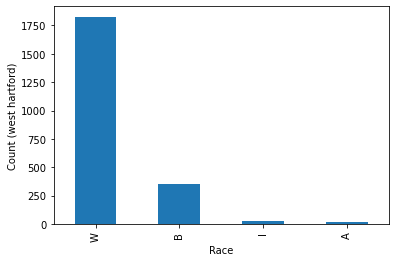

In [22]:
df_search[df_search['Department Name'] == 'west hartford'].SubjectRaceCode.value_counts().plot(kind='bar');
plt.xlabel('Race');
plt.ylabel('Count (west hartford)');


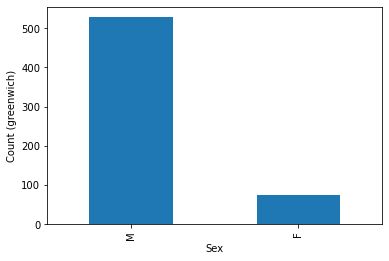

In [23]:
df_search[df_search['Department Name'] == 'greenwich'].SubjectSexCode.value_counts().plot(kind='bar');
plt.xlabel('Sex');
plt.ylabel('Count (greenwich)');

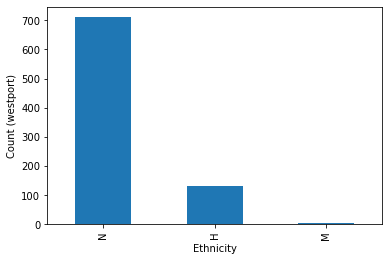

In [24]:
df_search[df_search['Department Name'] == 'westport'].SubjectEthnicityCode.value_counts().plot(kind='bar');
plt.xlabel('Ethnicity');
plt.ylabel('Count (westport)');

This points to the fact that we might have very underrepresented classes in our data, and optimizing for those might not be ideal. We can do a couple of changes to our function:

- add a threshold to avoid a small amount of samples to be factored in, only taking into account well-represented classes
- add a global measure of discrimination

See the implementation below:

In [25]:
def verify_no_discrimination(X_test, y_true, y_pred, sensitive_column='SubjectRaceCode', max_diff=0.05, min_samples=50):
    """
    Verifies that no subdeparment has discrimination in between protected races
    """
    
    departments = X_test['Department Name'].unique()
    sensitive_classes = X_test[sensitive_column].unique()
    
    is_satisfied = True
    problematic_departments = []
    good_deparments = []
    ignored_departments = []
    for department in departments:
        precisions = {}
        for sensitive_class in sensitive_classes:
            mask = (X_test[sensitive_column] == sensitive_class) & (X_test['Department Name'] == department)
            if np.sum(mask) > min_samples:
                precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
                
        if len(precisions) > 1:    
            diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))

            if diff > max_diff:
                is_satisfied = False
                problematic_departments.append((department, diff, precisions))
            else:
                good_deparments.append((department, diff, precisions))
        else:
            ignored_departments.append((department, None, []))
    
    global_precisions = {}
    for sensitive_class in sensitive_classes:
        mask = (X_test[sensitive_column] == sensitive_class)
        if np.sum(mask) > min_samples:
            global_precisions[sensitive_class] = precision_score(y_true[mask], y_pred[mask], pos_label=1)
    
    if len(precisions) > 1:    
        diff = np.max(list(precisions.values())) - np.min(list(precisions.values()))
        if diff > max_diff:
            is_satisfied = False
        
    return is_satisfied, problematic_departments, good_deparments, global_precisions



We can now re-run our verification code:

In [26]:
is_satisfied, problematic_departments, good_deparments, global_precisions = verify_no_discrimination(
    X_test_baseline, y_test_baseline, y_pred_baseline)


print("Race")

if not is_satisfied:
    print("Requirement failed 😢")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))

    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
        
print("\n\nGender")

is_satisfied, problematic_departments, good_deparments, global_precisions = verify_no_discrimination(
    X_test_baseline, y_test_baseline, y_pred_baseline, sensitive_column='SubjectSexCode')

if not is_satisfied:
    print("Requirement failed 😢")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))

    print("avg diff:", np.mean([p[1] for p in problematic_departments]))

print("\n\nEthnicity")

is_satisfied, problematic_departments, good_deparments, global_precisions = verify_no_discrimination(
    X_test_baseline, y_test_baseline, y_pred_baseline, sensitive_column='SubjectEthnicityCode')

if not is_satisfied:
    print("Requirement failed 😢")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))

    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
else:
    print("Requirement satisfied! 🚀")

print("Departments analysed: {}".format(len(problematic_departments) + len(good_deparments)))        

Race
Requirement failed 😢
Global rates: {'A': 0.5131578947368421, 'W': 0.5665961945031712, 'B': 0.4615141955835962, 'I': 0.5454545454545454}
Num problematic departments: 27
Num good departments: 12
avg diff: 0.1578197942623296


Gender
Requirement failed 😢
Global rates: {'M': 0.5317674691720493, 'F': 0.5443786982248521}
Num problematic departments: 19
Num good departments: 11
avg diff: 0.12856514081985473


Ethnicity
Requirement failed 😢
Global rates: {'N': 0.5444796490372897, 'H': 0.4975822050290135, 'M': 0.43}
Num problematic departments: 24
Num good departments: 10
avg diff: 0.1372623471471484
Departments analysed: 34


Our model still seems not to satisfy this requirement but not in such a terrible way as before.


<br>

###  3 - The largest possible amount of contraband found, given the constraints above

Finally, we want to maximize the contraband found. Well, this should be simple right? We want the highest possible number of true positives, despite also potentially having more false positives, within the other constraints. Once again, this should ring a bell:


$$
Recall = \frac{True Positives}{Total Existing Positives} = \frac{True Positives}{True Positives + False Negatives}
$$

We build a final function to provide this measure:



In [27]:
def verify_amount_found(y_true, y_pred):
    """
    Verifies the amout of contraband found in the test dataset - a.k.a the recall in our test set
    """
    
    recall = recall_score(y_true, y_pred, pos_label=True)    
    return recall


And we run it on our baseline:

In [28]:
verify_amount_found(y_test_baseline, y_pred_baseline)


0.6521483225426722

Since here we do not have a hard requirement to pass or fail, this value is as good as any other value, and only when we start working on the next iterations of the model, can we use it for comparison with the baseline.

Not bad for a first model, right? I mean, it's not like the cops were that efficient...

<img src="media/model-mistakes.png" width=600 />



<br>

### Fairness tradeoffs

On the next iteration, you might choose to remove the features that are directly tied to sensitive classes, such as race, gender and ethnicity.

In fact, let's see what would happen if you train a model with just the statute reason:

In [29]:
target = 'ContrabandIndicator'

all_features = [
  'StatuteReason', 
]

categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, all_features)])

pipeline = make_pipeline(
    preprocessor,
    RandomForestClassifier(max_depth=3, min_samples_leaf=.03, class_weight="balanced", random_state=42, n_jobs=-1),
)

X_train = df_train[all_features]
y_train = df_train[target]

pipeline.fit(X_train, y_train)

X_test = df_test[all_features]
y_test = df_test[target]

y_pred = pipeline.predict(X_test)

# To use on other cells
X_train_sensitive = X_train.copy()
X_test_sensitive = df_test.copy()
y_test_sensitive = X_test_baseline[target].copy()
y_pred_sensitive = y_pred.copy()
pipeline_sensitive = pipeline

roc_auc_score(y_test, y_pred)


0.5323198592368573

We had a small drop in the original metric (ROC_AUC), but what about our requirements? 

We'll now run all of the verification functions we built:

In [30]:
verify_success_rate_above(y_test_sensitive, y_pred_sensitive)


(False, 0.3767835124185309)

In [31]:
is_satisfied, problematic_departments, good_deparments, global_precisions = verify_no_discrimination(
    X_test_sensitive, y_test_sensitive, y_pred_sensitive)


print("Race")

if not is_satisfied:
    print("Requirement failed 😢")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))

    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
        
print("\n\nGender")

is_satisfied, problematic_departments, good_deparments, global_precisions = verify_no_discrimination(
    X_test_sensitive, y_test_sensitive, y_pred_sensitive, sensitive_column='SubjectSexCode')

if not is_satisfied:
    print("Requirement failed 😢")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))

    print("avg diff:", np.mean([p[1] for p in problematic_departments]))

print("\n\nEthnicity")

is_satisfied, problematic_departments, good_deparments, global_precisions = verify_no_discrimination(
    X_test_sensitive, y_test_sensitive, y_pred_sensitive, sensitive_column='SubjectEthnicityCode')

if not is_satisfied:
    print("Requirement failed 😢")
    print("Global rates: {}".format(global_precisions))
    print("Num problematic departments: {}".format(len(problematic_departments)))
    print("Num good departments: {}".format(len(good_deparments)))

    print("avg diff:", np.mean([p[1] for p in problematic_departments]))
else:
    print("Requirement satisfied! 🚀")

print("Departments analysed: {}".format(len(problematic_departments) + len(good_deparments)))

        

Race
Requirement failed 😢
Global rates: {'A': 0.3684210526315789, 'W': 0.39516666666666667, 'B': 0.33271604938271604, 'I': 0.2807017543859649}
Num problematic departments: 17
Num good departments: 22
avg diff: 0.09996879384231046


Gender
Requirement failed 😢
Global rates: {'M': 0.3742120343839542, 'F': 0.38847281015955715}
Num problematic departments: 23
Num good departments: 7
avg diff: 0.10884603633900546


Ethnicity
Requirement failed 😢
Global rates: {'N': 0.3952068386505877, 'H': 0.31659919028340083, 'M': 0.29464285714285715}
Num problematic departments: 23
Num good departments: 11
avg diff: 0.10419344690498486
Departments analysed: 34


In [32]:
verify_amount_found(y_test_sensitive, y_pred_sensitive)


0.755385520894644

So, if we summarize our two models, we get:


| Model |   Baseline    |  Second iteration   |  Best model |
|-------------------|---------|--------|--------| 
| Requirement 1 - success rate |     0.53  |  0.38  | 1 |
| Requirement 2 - global discrimination (race) |  0.105  |  0.11  | 1 |
| Requirement 2 - global discrimination (sex) | 0.012  | 0.014 | 1 |
| Requirement 2 - global discrimination (ethnicity) | 0.114  |  0.101   | 2 | 
| Requirement 2 - # department discrimination (race) | 27 |  17 | 2 |
| Requirement 2 - # department discrimination (sex) | 19 |  23 | 1 |
| Requirement 2 - # department discrimination (ethnicity) | 24 |  23  | 2 |
| Requirement 3 - contraband found (Recall) | 0.65  | 0.76  | 2 | 


So there are clearly pros and cons in each model, and in some cases you might need to make hard decisions. These 2 models are simple baselines, but even when you go further and optimize to reduce discrimination, for example, you may not be able to satisfy the first requirement. 

However you decide, the important thing is to explain well the process you used and explain to your client what are the trade-offs in place, as well as understand what they may want to prioritize.

Keep in mind that, in this case, if there were biases already in play, it might be hard to escape those, and you may want to suggest ways of tackling this problem further. For example, you may suggest that non-selected cars are searched at random to collect more data.


<br>

## Privacy requirements


Finally, there is always a level of privacy requirements that you need to account for. Even if your client does not request anything in particular in this sense, this is not something you can forget. So why do we care about privacy?

Most datasets we use for real-life applications have people's data, and with that any sort of personal information. Any such information that can potentially identify a specific individual is regarded as **personally identifiable information**. Some types of PII:

- Names
- Addresses
- Phone numbers
- Emails
- Medical information
- Payment values 
- ...

Some of these can be used to directly identify a person and some can be used together with other information to get there. All of it can be considered PII.


####  Why do you care?

- First, it is your ethical responsibility to make sure you protect the data you use when it contains sensitive information about any person (and we hope all academy students have this strong sense of ethics and want to have a positive impact)
- Even if you don't care about ethics, there are laws concerning privacy. _Looking at you, GDPR_


Not going to bore you with the details, but GDPR - General Data Protection Regulation - is a set of regulations that is in effect in all EU, that concern data protection and privacy. This regulation imposes that companies respect a set of individual rights of every person:

1. The right to be informed
1. The right of access
1. The right to rectification
1. The right to erasure (or right to be forgotten)
1. The right to restrict processing
1. The right to data portability
1. The right to object
1. Rights in relation to automated decision making and profiling

There are also other principles and a lot more details to it, and if you just search for it you can dive fully into it. But mostly what you need to know is that, since 2016, data protection is not just a perk that some companies offer, but it is actually mandatory.  



####  What can you do?

- avoid collecting PII that you won't need for your application 
- make sure the people working with the data have access only to the portion of data they need
- even if you need the PII for something, avoid replicating it in a lot of different places, using ids instead can work in some cases
- anonymize information whenever possible in a way that prevents completely or at least makes it more difficult to trace back this information
- encryption of data

These sound very abstract - and they are - because in every application there are different types of PII and protecting it completely is not an easy task.


<img src="media/everyone-gets-privacy.jpeg" width=400 />


<br>

## Prepare for deploy

We are going to decide to go with our first model. Even though it fails the second requirement, its recall is not terrible and the differences in the rates between classes are tolerable. 

We'll use what we've learned from the first BLU of this specialization to serialize our model.

In [33]:
with open('columns.json', 'w') as fh:
    json.dump(X_train_baseline.columns.tolist(), fh)
    
with open('dtypes.pickle', 'wb') as fh:
    pickle.dump(X_train_baseline.dtypes, fh)
    
joblib.dump(pipeline_baseline, 'pipeline.pickle');

We can now deploy our model and pray to the gods of production to spare us from different distributions!

<img src="media/surprised-pikachu.jpg" width=350 />


Move on to the next BLU to see what other problems you can fight when sending your model out to the wild.